# BEE 4750 Homework 4: Linear Programming and Capacity Expansion

**Name**: Raashid Husain

**ID**:RAH383

> **Due Date**
>
> Thursday, 10/31/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to formulate and solve a resource allocation
    problem using linear programming.
-   Problem 2 asks you to formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   Problem 3 (5750 only) asks you to add a CO<sub>2</sub> constraint to
    the capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Downloads/BEE 4750/hw4-raashid-husain`


In [3]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 50/60 Points)

### Problem 1 (20 points)

A farmer has access to a pesticide which can be used on corn, soybeans,
and wheat fields, and costs \$70/kg-yr to apply. The crop yields the
farmer can obtain following crop yields by applying varying rates of
pesticides to the field are shown in
<a href="#tbl-yields" class="quarto-xref">Table 1</a>.

| Application Rate (kg/ha) | Soybean (kg/ha) | Wheat (kg/ha) | Corn (kg/ha) |
|:------------------------:|:---------------:|:-------------:|:------------:|
|            0             |      2900       |     3500      |     5900     |
|            1             |      3800       |     4100      |     6700     |
|            2             |      4400       |     4200      |     7900     |

Table 1: Crop yields from applying varying pesticide rates for Problem
1.

The costs of production, *excluding pesticides*, for each crop, and
selling prices, are shown in
<a href="#tbl-costs" class="quarto-xref">Table 2</a>.

|   Crop   | Production Cost (\$/ha-yr) | Selling Price (\$/kg) |
|:--------:|:--------------------------:|:---------------------:|
| Soybeans |            350             |         0.36          |
|  Wheat   |            280             |         0.27          |
|   Corn   |            390             |         0.22          |

Table 2: Costs of crop production, excluding pesticides, and selling
prices for each crop.

Recently, environmental authorities have declared that farms cannot have
an *average* application rate on soybeans, wheat, and corn which exceeds
0.8, 0.7, and 0.6 kg/ha, respectively. The farmer has asked you for
advice on how they should plant crops and apply pesticides to maximize
profits over 130 total ha while remaining in regulatory compliance if
demand for each crop (which is the maximum the market would buy) this
year is 250,000 kg?

**In this problem**:

-   Formulate a linear program for this resource allocation problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations). **Tip: Make sure that all of your constraints are
    linear**.
-   Implement the program in `JuMP.jl` and find the solution. How many
    ha should the farmer dedicate to each crop and with what pesticide
    application rate(s)? How much profit will the farmer expect to make?
-   The farmer has an opportunity to buy an extra 10 ha of land. How
    much extra profit would this land be worth to the farmer? Discuss
    why this value makes sense and whether you would recommend the
    farmer should make the purchase.

In [4]:
crop_model = Model(HiGHS.Optimizer)

# Yields associated with different application rates (kg/ha)
pest_yields = Dict(0 => (2900, 3500, 5900), 1 => (3800, 4100, 6700), 2 => (4400, 4200, 7900))

# Production Costs $/ha-yr (from Table 2)
C_s = 350
C_w = 280
C_c = 390

# Selling Prices $/kg (from Table 2)
P_s = 0.36
P_w = 0.27
P_c = 0.22

@variable(crop_model, A_s0 >= 0) 
@variable(crop_model, A_s1 >= 0)
@variable(crop_model, A_s2 >= 0)

@variable(crop_model, A_w0 >= 0)
@variable(crop_model, A_w1 >= 0)
@variable(crop_model, A_w2 >= 0)

@variable(crop_model, A_c0 >= 0)
@variable(crop_model, A_c1 >= 0)
@variable(crop_model, A_c2 >= 0)

@constraint(crop_model, A_s0+A_s1+A_s2 + A_w0+A_w1+A_w2 + A_c0+A_c1+A_c2 <= 140)

# Objective
@objective(crop_model, Max,
    (pest_yields[0][1] * A_s0 * P_s + 
     pest_yields[1][1] * A_s1 * P_s + 
     pest_yields[2][1] * A_s2 * P_s + 
     pest_yields[0][2] * A_w0 * P_w + 
     pest_yields[1][2] * A_w1 * P_w + 
     pest_yields[2][2] * A_w2 * P_w + 
     pest_yields[0][3] * A_c0 * P_c + 
     pest_yields[1][3] * A_c1 * P_c + 
     pest_yields[2][3] * A_c2 * P_c) - 
    (C_s * (A_s0 + A_s1 + A_s2) + 
     C_w * (A_w0 + A_w1 + A_w2) + 
     C_c * (A_c0 + A_c1 + A_c2) + 
     70*((A_s1 + 2*A_s2) + (A_w1 + 2*A_w2) + (A_c1 + 2*A_c2)))
)

@constraint(crop_model, (0*A_s0 + 1*A_s1 + 2*A_s2) <= 0.8*(A_s0 + A_s1 + A_s2))
@constraint(crop_model, (0*A_w0 + 1*A_w1 + 2*A_w2) <= 0.7*(A_w0 + A_w1 + A_w2))
@constraint(crop_model, (0*A_c0 + 1*A_c1 + 2*A_c2) <= 0.6*(A_c0 + A_c1 + A_c2))

@constraint(crop_model, pest_yields[0][1] * A_s0 + pest_yields[1][1] * A_s1 + pest_yields[2][1] * A_s2 <= 250000)
@constraint(crop_model, pest_yields[0][2] * A_w0 + pest_yields[1][2] * A_w1 + pest_yields[2][2] * A_w2 <= 250000)
@constraint(crop_model, pest_yields[0][3] * A_c0 + pest_yields[1][3] * A_c1 + pest_yields[2][3] * A_c2 <= 250000)

optimize!(crop_model)

println("Area of soybeans with 0 rate: ", value(A_s0))
println("Area of soybeans with 1 rate: ", value(A_s1))
println("Area of soybeans with 2 rate: ", value(A_s2))

println("Area of wheat with 0 rate: ", value(A_w0))
println("Area of wheat with 1 rate: ", value(A_w1))
println("Area of wheat with 2 rate: ", value(A_w2))

println("Area of corn with 0 rate: ", value(A_c0))
println("Area of corn with 1 rate: ", value(A_c1))
println("Area of corn with 2 rate: ", value(A_c2))

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 8e+03]
  Cost   [7e+02, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 2e+05]
Presolving model
7 rows, 9 cols, 27 nonzeros  0s
7 rows, 9 cols, 27 nonzeros  0s
Presolve : Reductions: rows 7(-0); columns 9(-0); elements 27(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.8170297740e+02 Ph1: 7(28.3601); Du: 9(181.703) 0s
          7     1.2403516702e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  1.2403516702e+05
HiGHS run time      :          0.00
Area of soybeans with 0 rate: 13.8121546961326
Area of soybeans with 1 rate: 55.24861878453038
Area of soybeans with 2 rate: 0.0
Area of wheat with 0 rate: 9.743306417339566
Area of wheat with 1 rate: 22.734381640458977
Area of wheat with 2 ra

#### Discussion and Results

The linear program was written out in the first part of the problem and I implemented it into the JuMP.jl form in the code above to get the following values of how many hectares of land the farmer should dedicate to each crop and with what application rates:

- Area of soybeans with 0 rate: 13.812154696132604
- Area of soybeans with 1 rate: 55.24861878453038
- Area of soybeans with 2 rate: 0.0
- Area of wheat with 0 rate: 6.743306417339563
- Area of wheat with 1 rate: 15.734381640458977
- Area of wheat with 2 rate: 0.0
- Area of corn with 0 rate: 26.92307692307692
- Area of corn with 1 rate: 0.0
- Area of corn with 2 rate: 11.538461538461547

According to the optimization model, the farmer will make a profit of **$116,741.17** with **130 hectares of land**.

When I changed the maximum amount of land available to 140 ha since the farmer is considering buying 10 ha, the new profit was **$124,035.17** meaning the farmer would earn an extra **$7,294** with the extra 10 hectares. This value makes sense since more land is available for use to be farmed and the optimization increases the amount of wheat produced with 0 and 1 application rates. This occurs so that the environmental restrictions are still upheld while the amount of crop produced is still maximized. I would recommend the farmer make this purchase since the farmer can still stay within the range of environmental restrictions and still advance profitability by planting wheat. 

### Problem 2 (30 points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

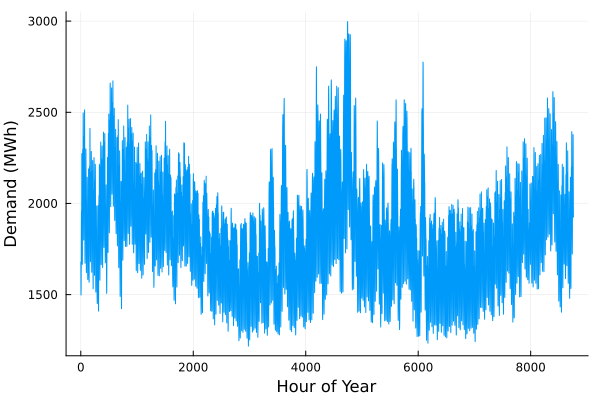

In [37]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data, shown in
<a href="#tbl-generators" class="quarto-xref">Table 3</a>. This data
includes fixed costs (\$/MW installed), variable costs (\$/MWh
generated), and CO<sub>2</sub> emissions intensity (tCO<sub>2</sub>/MWh
generated).

In [38]:
gens = DataFrame(CSV.File("data/generators.csv"))

Row,Plant,FixedCost,VarCost,Emissions
,String15,Int64,Int64,Float64
1,Geothermal,450000,0,0.0
2,Coal,220000,24,1.0
3,NG CCGT,82000,30,0.43
4,NG CT,65000,40,0.55
5,Wind,91000,0,0.0
6,Solar,70000,0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

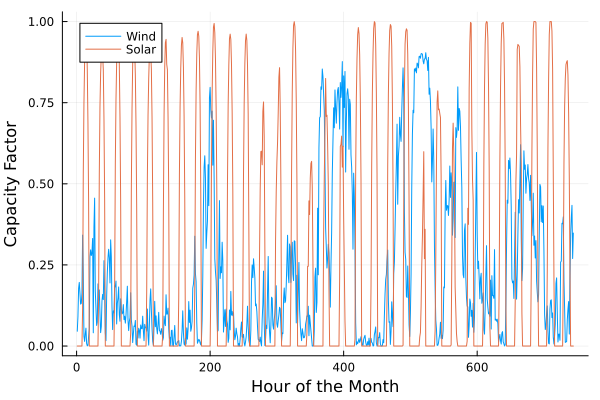

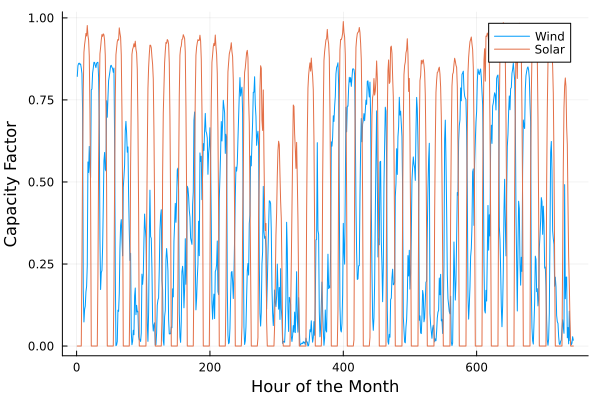

8760


In [39]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)
println(nrow(cap_factor))

You have been asked to develop a generating capacity expansion plan for
the utility in Riley County, NY, which currently has no existing
electrical generation infrastructure. The utility can build any of the
following plant types: geothermal, coal, natural gas combined cycle gas
turbine (CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$10,000/MWh.

**In this problem**:

-   Formulate a linear program for this capacity expansion problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations).
-   Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?
-   What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in the previous part of this problem? Do these results make sense given the generator
    data?
-   Make a plot of the electricity price in each hour. Discuss any
    trends that you see.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision! If your number is on a different order of magnitude and you
> want to round to a certain number of significant digits, you can use
> `round(x; sigdigits=n)`.

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

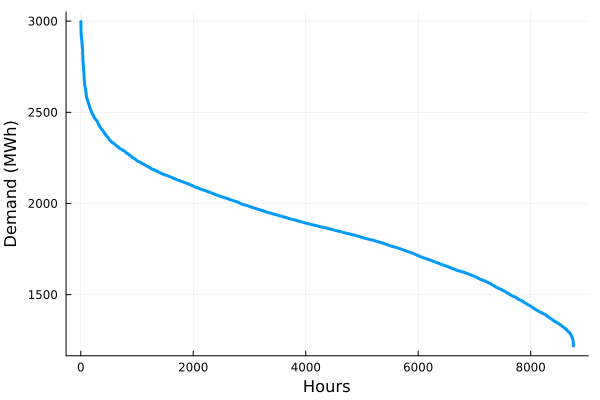

In [40]:
plot(sort(demand.Demand, rev=true), linewidth=3, label=:false)
xaxis!("Hours")
yaxis!("Demand (MWh)")

In [41]:
# define sets
G = 1:nrow(gens[1:end, :])
T = 1:nrow(demand)
NSECost = 10000

num_hours = nrow(cap_factor)  # 8760 hours total

c = zeros(Float64, length(G), num_hours)

# Capacity factors for all 6 generator types for constraints
for g in G
    if g in [2, 3, 4]  # Rows of Coal, NG CCGT, NG CT in gens
        c[g, :] .= 1.0
    elseif g == 1  # Geothermal row in gens
        c[g, :] .= 0.85
    elseif g == 5  # Wind row in gens
        c[g, :] .= cap_factor.Wind
    elseif g == 6  # Solar row in gens
        c[g, :] .= cap_factor.Solar
    end
end

gencap = Model(HiGHS.Optimizer)

@variables(gencap, begin
    x[g in G] >= 0
    y[g in G, t in T] >= 0
    NSE[t in T] >= 0
end)

@objective(gencap, Min, 
    sum(gens[G, :FixedCost] .* x) + sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE)
)

@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= demand.Demand[t])
@constraint(gencap, capacity[g in G, t in T], 
    y[g, t] <= x[g] * c[g, t]) # capacity constraint

optimize!(gencap)

total = objective_value(gencap)
rounded = round(total; sigdigits=3)
println("Total cost of generation: $rounded")

total_NSE = sum(value(NSE[t]) for t in T)
rounded_NSE = round(total_NSE; digits=2)
println("Total non-served energy: $rounded_NSE")

total_installed_capacity = sum(value(x[g]) for g in G)

for g in G
    optimal_capacity = round(value(x[g]); digits=1)
    fraction_capacity = optimal_capacity / total_installed_capacity
    println("Optimal capacity for generator $g: $optimal_capacity MW")
    println("Fraction of total capacity for generator $g: $(round(fraction_capacity; digits=3))")
end

annual_generation = zeros(Float64, length(G))

for g in G
    annual_generation[g] = sum(value(y[g, t]) for t in T)
end

total_annual_generation = sum(annual_generation)

for g in G
    generated_amount = annual_generation[g]
    fraction_generated = generated_amount/total_annual_generation
    println("Amount generated by generator $g: $(round(generated_amount; digits=1)) MWh")
    println("Fraction of total generation for generator $g: $(round(fraction_generated; digits=3))")
end

y_values = value.(y)
x_values = value.(x)

Pmin = zeros(Float64, length(G))
Pmax = zeros(Float64, length(G))

for g in G
    Pmin[g] = minimum(y_values[g, :])
    Pmax[g] = x_values[g]
end

gens.Pmin = Pmin
gens.Pmax = Pmax

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [5e-05, 1e+00]
  Cost   [2e+01, 4e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+03, 3e+03]
Presolving model
56856 rows, 56862 cols, 153048 nonzeros  0s
56853 rows, 56859 cols, 153042 nonzeros  0s
Presolve : Reductions: rows 56853(-4467); columns 56859(-4467); elements 153042(-8934)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.1747e+06) 0s
      42008     6.5458487038e+08 Pr: 0(0); Du: 0(2.80224e-10) 2s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 42008
Objective value     :  6.5458487038e+08
HiGHS run time      :          2.41
Total cost of generation: 6.55e8
Total non-served energy: 256.83
Optimal capacity for generator 1: -0.0 MW
Fraction of total capacity for generator 1: -0.0
Optimal 

6-element Vector{Float64}:
   -0.0
    0.0
 1658.4514133074133
  879.7538120149645
  484.946167110047
 1957.6424239086684

#### Discussion and Results

After writing out the linear program manually, I implemented in code by adapting the lecture slides and creating appropriate constraints given the solar and wind data. I found that the total cost would be **$6.55e8** based on the objective function's solution. The amount of non-served energy is **256.83 MWh** Furthermore, the amount of each generator that the utility should build is summarized (with percentages) in the table below (not in code but made externally and pasted in final report). 

The breakdown of the amount of generation and the corresponding percent of total electricity generation is also provided in the table below (not in code, part of external report). Compared to the installed capacity, the NG CCGT plant is generating a larger percentage of electricity than percentage of installed while NG CT is producing much less electricity compared to the percent built by the utility. For both installed and generated electricity, geothermal and coal are both 0 since none is installed. Wind and Solar plants have a similar percent of installed share and generation share. Therefore, the tradeoff is mostly between NG CCGT and NG CT plants. This makes sense because NG CT has a higher variable cost which will catch up to the difference in fixed cost if a lot more electricity is produced by the NG CT. Therefore, since the NG CCGT has a lower variable cost compared to NG CT, it will take a larger share of the electricity generation despite the higher fixed cost.

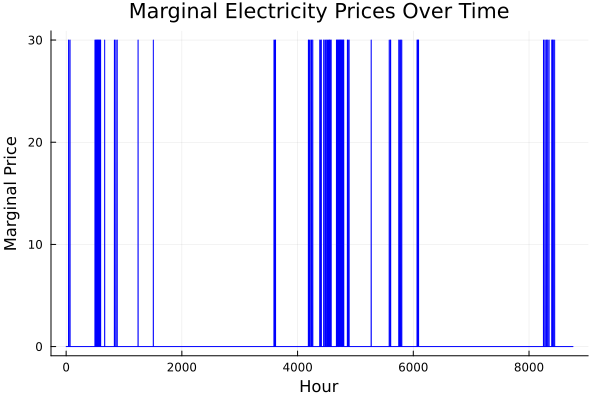

In [56]:
G = 1:nrow(gens)
NSECost = 10000
marginal_prices = zeros(Float64, nrow(demand))

function plot_supply_curve(supply_curve, demand) 
    marg_gen = 0 
    marg_price = 0 
    x = 0 

    x = x + sum(supply_curve.Pmin) 
    for i in 1:nrow(supply_curve) 
        if (x < demand) && (x + supply_curve[i,:cap] > demand) 
            marg_gen = i 
            marg_price = supply_curve[i,:VarCost] 
        end 
        x = x + supply_curve[i,:cap] 
    end 

    return marg_price
end 

gens.cap = gens[:, :Pmax] .- gens[:, :Pmin]
gens_nr = sort!(gens[G, :], [:VarCost, order(:cap, rev=true)])

for t in 1:nrow(demand)
    marg_price = plot_supply_curve(gens_nr, demand.Demand[t])
    marginal_prices[t] = marg_price
end

plot(1:nrow(demand), marginal_prices, 
     xlabel="Hour", ylabel="Marginal Price", 
     title="Marginal Electricity Prices Over Time", 
     legend=false, linecolor="blue")

#### Discussion and Results of Electricity Graph

I adapted the code from Lecture 15 to calculate the marginal price at each hour. I believe there be more lines than there are supposed to be because of some miscalculation in how I got Pmin and Pmax or some other error but the general behavior seems correct based on the given demand data. This graph displays the electricity prices based on the marginal cost of the last amount of electricity needed to meet the demand at that time (shadow price as discussed in lecture). This graph makes sense with the given demand data because when the demand/load is peaks and fluctuates extensively (in the early and middle months of the year and the last couple weeks of December), electricity prices are the highest. Otherwise, the electricity price is 0 since the geneartors meet the demand with their capacity.

## References

List any external references consulted, including classmates.

- Problem 1: How to create a dictionary in Julia (for Table 1 values): https://discourse.julialang.org/t/create-a-dictionary-from-arrays-of-keys-and-values/13908 